# Plane's Windows

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1/ With this information and no more, formulate the problem, and tell him what is feasible and what is not.

2/ Develop an approach to answer his question in the best way possible.

3/ Present your findings to the expert, in a way he can understand and help you validate your results...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.decomposition import PCA

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [3]:
data = pd.read_csv("./data/dataset.csv")

# Assimiler chaque Fenêtre à sa moyenne

On va regarder s'il existe des "gros" outliers (données n'étant pas du même ordre de grandeur) dans le dataset. Si c'est le cas, on retirera ces valeurs. Pour ce faire, nous allons comparer la moyenne et la médiane de chaque fenêtre. Si l'écart entre ces deux valeurs est élevé, cela signifie qu'un "gros" outlier se situe dans la fenêtre considérée.

In [49]:
df_med = data.groupby(['day_cycle_window']).median()
df_mean = data.groupby(['day_cycle_window']).mean()

windows = sorted(list(set(data['day_cycle_window'])))
print(windows.index('3_3_181'))

distances = []

for i in range(df_mean.shape[0]):
    dist = 0
    for col in df_mean.columns:
        dist += abs((df_mean[col][i]-df_med[col][i])/np.max([abs(df_mean[col][i]), abs(df_med[col][i])]))
    distances.append(round(dist,2))

print(np.max(distances))

# window = data[data['day_cycle_window']=='2_3_105']

1092


<ipython-input-49-b9b49d5e9a94>:12: RuntimeWarning: invalid value encountered in double_scalars
  dist += abs((df_mean[col][i]-df_med[col][i])/np.max([abs(df_mean[col][i]), abs(df_med[col][i])]))


nan


As the distances are relatively small, we will represent each window by its mean.

In [6]:
df = df_mean

### ACP

In [7]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

print("Explained variance : {}%".format(round(np.sum(pca.explained_variance_ratio_)*100,2)))

Explained variance : 75.63%


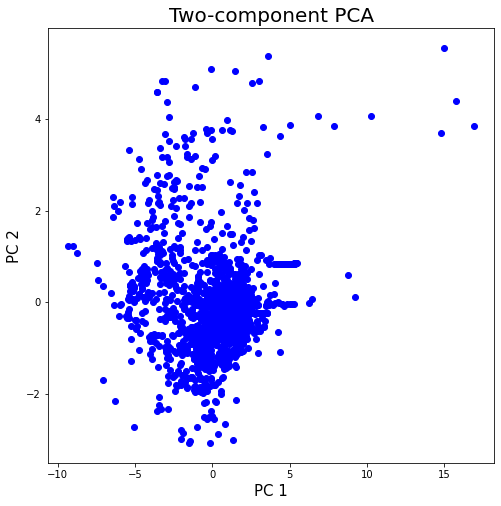

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

### Méthodes d'outliers

In [9]:
def fit_predict(df, clf):
    clf.fit(df)
    ypred = clf.predict(df)
    return ypred

def plot2D(df, clf_name, contaminations, fig, ypred, i):
    ax = fig.add_subplot(int(len(contaminations)+1/2),2,i+1)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA \n Method : {} \n Contamination rate : {}'.format(clf_name,round(contaminations[i],3)))
    plt.scatter(df["principal component 1"], df["principal component 2"], color='b', label='Valid data')
    plt.plot(df["principal component 1"][ypred==-1],df["principal component 2"][ypred==-1],'r.', label='Anomalies')
    plt.legend(loc='upper right')

In [10]:
def runAnomalies(df, clf_name, contaminations, display=True):
    
    if display:
        fig = plt.figure(figsize=(20,10*int(len(contaminations)+1/2)))
        
    if clf_name == 'SVM':
        for i in range(len(contaminations)):
            # Create classificator
            clf = OneClassSVM(nu=contaminations[i], kernel="rbf", gamma=0.3)
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'Elliptic':
        for i in range(len(contaminations)):
            # Create classificator
            clf = EllipticEnvelope(contamination=contaminations[i])
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'Forest':
        for i in range(len(contaminations)):
            # Create classificator
            clf = IsolationForest(behaviour='new', n_estimators=100, contamination=contaminations[i])
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'LOF':
        for i in range(len(contaminations)):
            # Create classificator
            clf = LocalOutlierFactor(n_neighbors=5, contamination=contaminations[i], novelty=True)
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    else:
        print("Error : The method is not known. Please select either 'SVM', 'Elliptic', 'Forest' or 'LOF'.")
        
    return ypred

array([-1, -1,  1, ...,  1,  1,  1])

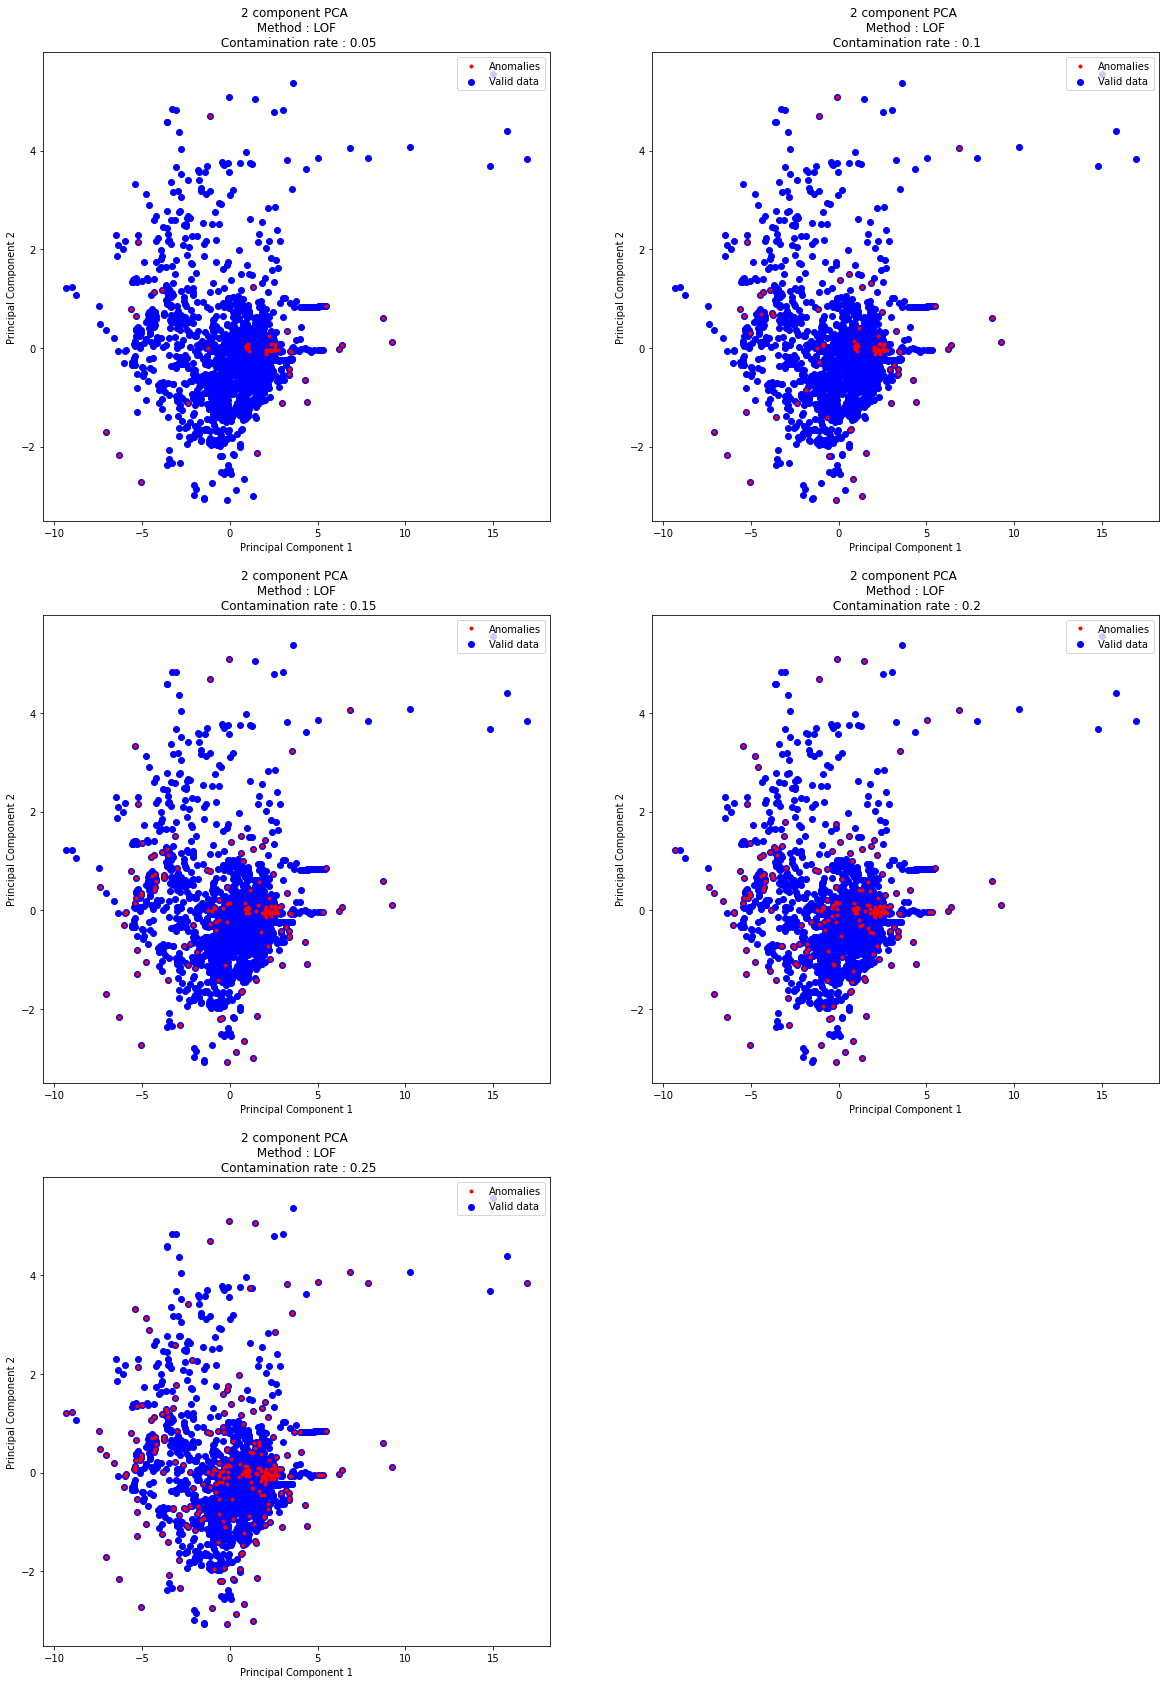

In [11]:
contaminations = np.linspace(0.05,0.25,5)
clf_name = "LOF"
runAnomalies(principalDf, clf_name, contaminations)

On regarde si une donnée est détectée par plusieurs méthodes grâce au score d'une donnée. On définit le score comme étant le nombre de méthodes qui ont détécté une fenêtre comme étant une anomalie. 
Pour éviter un temps de calcul trop long, nous menons cette étude pour seulement une valeur de contamination rate égale à 0,15.

In [12]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]
predictions = []
for clf_name in methods:
    print("Method : {}".format(clf_name))
    predictions.append(runAnomalies(principalDf, clf_name, [0.1], False))

Method : Elliptic
Method : LOF
Method : SVM
Method : Forest


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


In [14]:
def score (predictions, i):
    score = 0
    for j in range(len(predictions)):
        if predictions[j][i] == -1:
            score += 1
    return score

scores = [score(predictions, i) for i in range(len(predictions[0]))]
print("Rate of anomalies : {}%".format(round(np.count_nonzero(scores)/len(scores)*100,2)))

anomaly_windows = [windows[i] for i in range(len(scores)) if scores[i] > 0]

Rate of anomalies : 19.98%


# Analyse de toutes les données   

Nous allons mener l'étude précédente, mais cette fois-ci avec toutes les données. Une fenêtre sera définie comme anormale si 50% de ses valeurs sont détectées comme étant des anomalies.

In [15]:
print(data.columns)
df = data.drop(['day_cycle_window'], axis=1)

Index(['day_cycle_window', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8',
       'p9', 'p10', 'p11'],
      dtype='object')


Explained variance : 74.3%


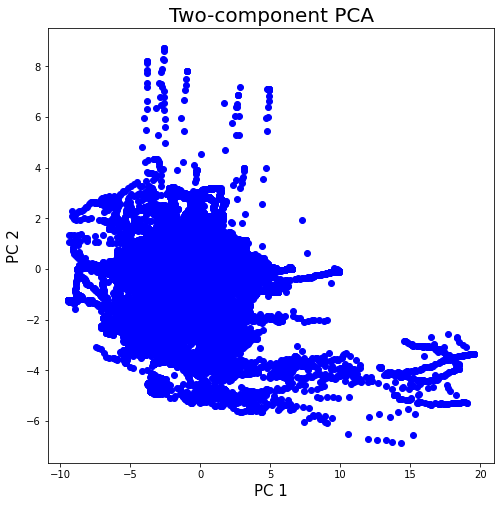

In [16]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

print("Explained variance : {}%".format(round(np.sum(pca.explained_variance_ratio_)*100,2)))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

array([1, 1, 1, ..., 1, 1, 1])

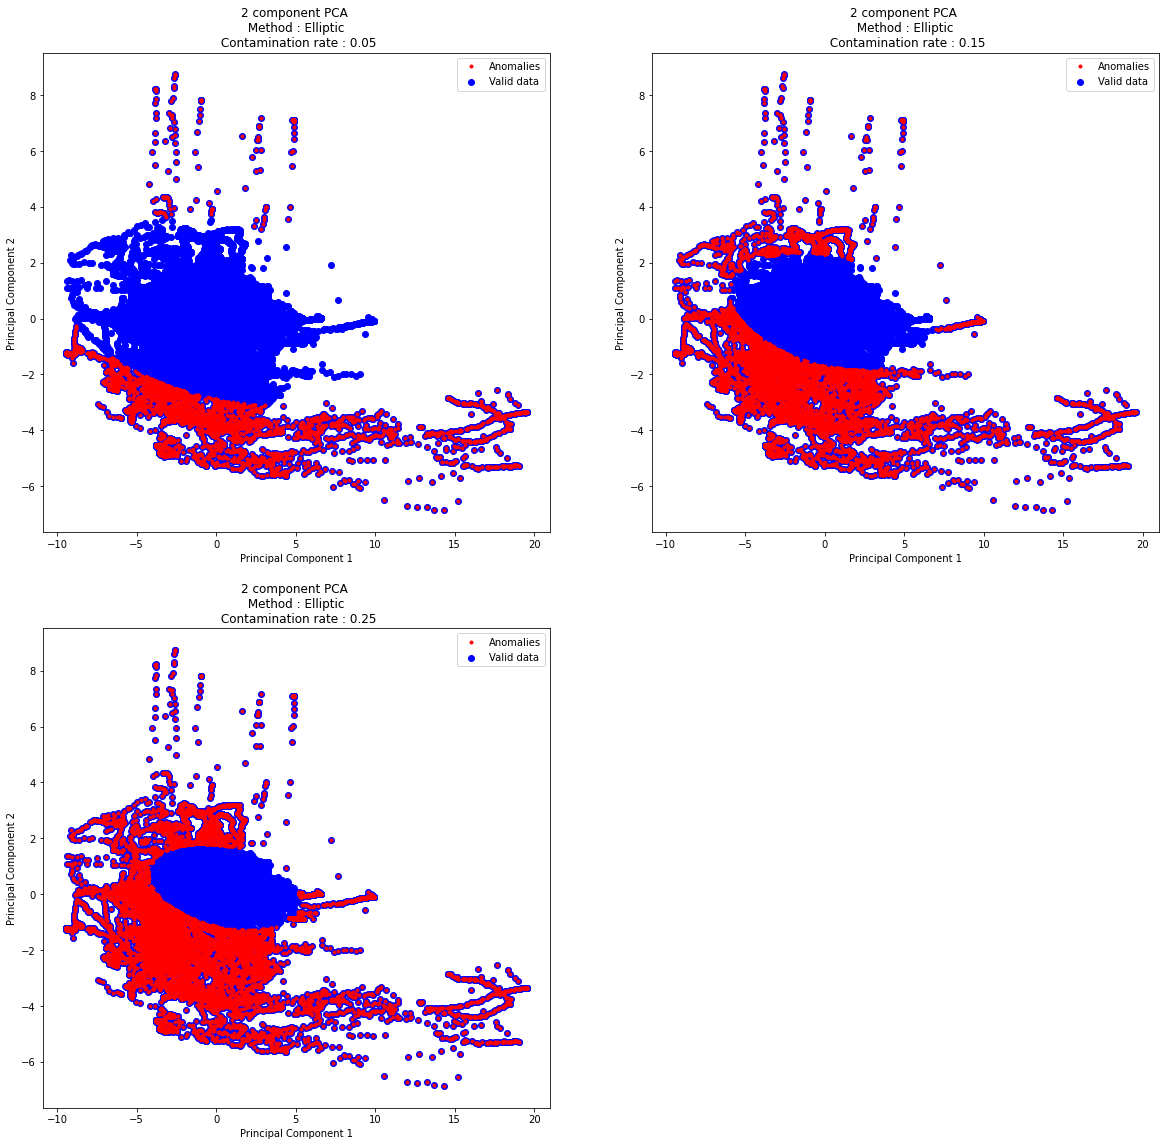

In [17]:
contaminations = np.linspace(0.05,0.25,3)
clf_name = "Elliptic"
runAnomalies(principalDf, clf_name, contaminations)

On effectue les quatre méthodes de détection

In [18]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]
predictions = []
for clf_name in methods:
    print("Method : {}".format(clf_name))
    predictions.append(runAnomalies(principalDf, clf_name, [0.1], False))

Method : Elliptic
Method : LOF
Method : SVM
Method : Forest


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


On calcule le score d'anomalie pour chaque donnée. On rajoute au tableau une colonne 'Score' et une colonne 'Anomaly' qui vaut 1 si la donnée est une anomalie, 0 sinon.

In [59]:
def score(predictions, i):
    score = 0
    for j in range(len(predictions)):
        if predictions[j][i] == -1:
            score += 1
    return score

data_scores = [score(predictions, i) for i in range(len(predictions[0]))]
print("Rate of anomalies : {}%".format(round(np.count_nonzero(data_scores)/len(data_scores)*100,2)))

data["Score"] = data_scores

data["Anomaly"] = [data["Score"][i] > 1 for i in range(len(predictions[0]))]

data.head()

Rate of anomalies : 21.76%


,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score,Anomaly
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,0,False
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,0,False
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,0,False
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,0,False
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,1,False


On regarde le score moyen des données au sein de chaque fenêtre.

In [60]:
df_windows = data.groupby(['day_cycle_window']).mean()

print(len(df_windows[df_windows["Score"] > 1]))

df_windows.head()

203


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score,Anomaly
day_cycle_window,,,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060,2.62,0.92
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565,0.09,0.00
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938,0.05,0.00
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699,0.03,0.00
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059,0.29,0.00


In [68]:
n_data_window = data.groupby(['day_cycle_window']).agg(['count'])['p1'].sort_values(by=['day_cycle_window'])

df_windows = data.groupby(['day_cycle_window']).sum()
df_windows["Anomaly Rate"] = df_windows["Anomaly"]/n_data_window['count']

df_windows = df_windows.loc[:,["Anomaly Rate"]]

df_windows["Is an Anomaly"] = [df_windows["Anomaly Rate"][i] > 0.5 for i in range(len(df_windows["Anomaly Rate"]))]

print(len(df_windows[df_windows["Anomaly Rate"] > 0.5]))
df_windows.head()

153


,Anomaly Rate,Is an Anomaly
day_cycle_window,,
1_1_1,0.92,True
1_1_10,0.00,False
1_1_11,0.00,False
1_1_12,0.00,False
1_1_13,0.00,False


In [ ]:
anomaly_windows = [windows_scores[i] for i in range(len(windows_scores)) if windows_scores[i] > 0.2]
print(len(anomaly_windows))